To calculate the **Overall Frozen Market Index**, you'll combine your four sub-indices:

* **Labor Market Tightness Index** (Tightness)
* **Labor Market Distress Index** (Distress)
* **Labor Market Mobility & Confidence Index** (Mobility)
* **Labor Compensation Pressure Index** (Compensation)

---

### 🎯 **Conceptual Logic**

A “frozen” labor market typically shows:

* **Low Tightness** (↓ demand for labor)
* **High Distress** (↑ unemployment/slack)
* **Low Mobility/Confidence** (↓ voluntary quits, ↑ layoffs)
* **Low Compensation Pressure** (↓ wage growth, ↓ work hours)

So your **Frozen Market Index** should:

* **Inversely reflect Tightness, Mobility, Compensation**
* **Directly reflect Distress**

---

### ✅ Formula (standardized direction):

```python
Frozen_Market_Index = (
    -1 * zscore(Tightness_Index)
    + 1 * zscore(Distress_Index)
    -1 * zscore(Mobility_Confidence_Index)
    -1 * zscore(Compensation_Pressure_Index)
) / 4
```

---

### 🧠 Why This Makes Sense

| Component                   | Freeze Signal  | Direction |
| --------------------------- | -------------- | --------- |
| Labor Tightness Index       | ↓ Tightness    | Negative  |
| Labor Distress Index        | ↑ Distress     | Positive  |
| Mobility & Confidence Index | ↓ Mobility     | Negative  |
| Compensation Pressure Index | ↓ Compensation | Negative  |

---

### 🧪 Code Example

Assuming you already have a DataFrame `all_indices_df` with these columns:

```python
['Labor_Market_Tightness_Index',
 'Labor_Market_Distress_Index',
 'Labor_Market_Mobility_Confidence_Index',
 'Labor_Compensation_Pressure_Index']
```

You can calculate the frozen index like this:

```python
from scipy.stats import zscore

# Z-score each index
all_indices_df['Tightness_z'] = zscore(all_indices_df['Labor_Market_Tightness_Index'], nan_policy='omit')
all_indices_df['Distress_z'] = zscore(all_indices_df['Labor_Market_Distress_Index'], nan_policy='omit')
all_indices_df['Mobility_z'] = zscore(all_indices_df['Labor_Market_Mobility_Confidence_Index'], nan_policy='omit')
all_indices_df['Compensation_z'] = zscore(all_indices_df['Labor_Compensation_Pressure_Index'], nan_policy='omit')

# Combine into the Frozen Market Index
all_indices_df['Frozen_Market_Index'] = (
    -all_indices_df['Tightness_z'] +
     all_indices_df['Distress_z'] -
     all_indices_df['Mobility_z'] -
     all_indices_df['Compensation_z']
) / 4
```

---

### 📈 Optional: Plot It

```python
all_indices_df.set_index('observation_date')['Frozen_Market_Index'].plot(
    title='Overall Frozen Labor Market Index',
    figsize=(12, 5)
)
```

---

Would you like to threshold this into freeze levels (e.g., Normal / Stagnating / Frozen) or visualize it with recession overlays?


In [26]:
import pandas as pd
from scipy.stats import zscore

import os

# Load each index CSV
tight_df = pd.read_csv('Labor_Market_Tightness_Index.csv')
distress_df = pd.read_csv('Labor_Market_Distress_Index.csv')
mobility_df = pd.read_csv('Labor_Market_Mobility_Confidence_Index.csv')
comp_df = pd.read_csv('Labor_Compensation_Pressure_Index.csv')


# Merge all on observation_date
frozen_df = tight_df.merge(distress_df, on='observation_date') \
                    .merge(mobility_df, on='observation_date') \
                    .merge(comp_df, on='observation_date')

# Rename columns for clarity
frozen_df.rename(columns={
    'Labor_Market_Tightness_Index': 'Tightness',
    'Labor_Market_Distress_Index': 'Distress',
    'Labor_Market_Mobility_Confidence_Index': 'Mobility',
    'Labor_Compensation_Pressure_Index': 'Compensation'
}, inplace=True)

# Calculate z-scored Frozen Market Index
frozen_df['Frozen_Market_Index'] = (
    -zscore(frozen_df['Tightness'], nan_policy='omit') +
     zscore(frozen_df['Distress'], nan_policy='omit') -
     zscore(frozen_df['Mobility'], nan_policy='omit') -
     zscore(frozen_df['Compensation'], nan_policy='omit')
) / 4

# Optional: Save final frozen index to CSV
os.makedirs('Frozen_Market', exist_ok=True)
frozen_df[['observation_date', 'Frozen_Market_Index']].to_csv(
    'Frozen_Market/Frozen_Market_Index.csv', index=False
)

import pandas as pd

# Load the Frozen Market Index data
frozen_df = pd.read_csv('Frozen_Market/Frozen_Market_Index.csv')
frozen_df['observation_date'] = pd.to_datetime(frozen_df['observation_date'])

# Automatically assign labels based on quantiles
frozen_df['Frozen_Label'] = pd.qcut(
    frozen_df['Frozen_Market_Index'],
    q=4,
    labels=['Thawed', 'Stable', 'Cooling', 'Frozen']
)

# Overwrite the original file with labels included
frozen_df.to_csv('Frozen_Market/Frozen_Market_Index.csv', index=False)


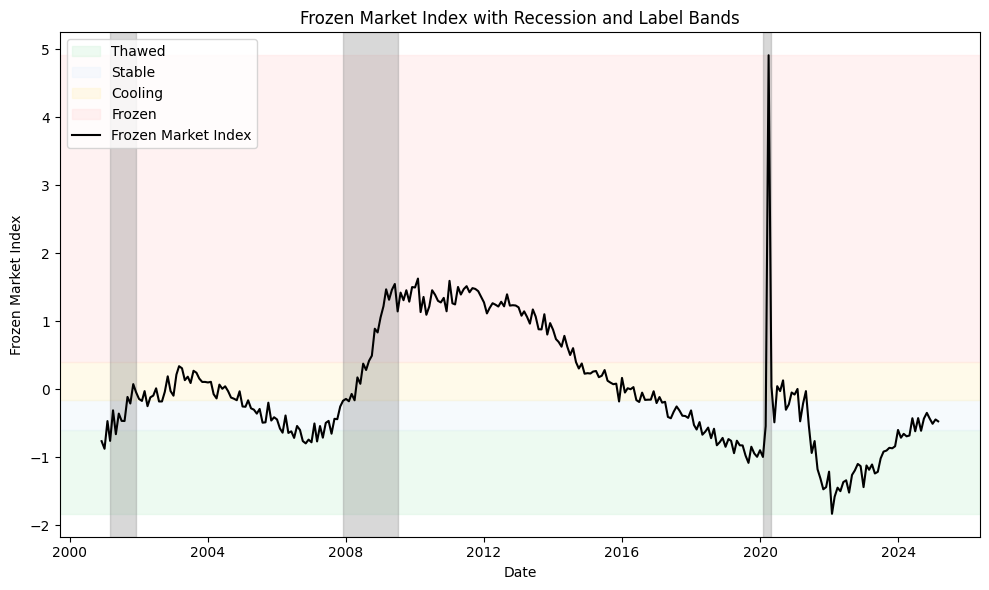

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert dates
frozen_df['observation_date'] = pd.to_datetime(frozen_df['observation_date'])

# Define recession periods
recession_periods = [
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30'),
]

# Determine Y ranges for each label using quantiles
q = frozen_df['Frozen_Market_Index'].quantile([0.0, 0.25, 0.5, 0.75, 1.0])
label_ranges = [
    (q[0.00], q[0.25], 'Thawed', '#d4f4dd'),
    (q[0.25], q[0.50], 'Stable', '#eaf4fc'),
    (q[0.50], q[0.75], 'Cooling', '#fff4cc'),
    (q[0.75], q[1.00], 'Frozen', '#ffe0e0')
]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Add shaded horizontal bands for each label
for ymin, ymax, label, color in label_ranges:
    ax.axhspan(ymin, ymax, color=color, alpha=0.4, label=label)

# Plot line
ax.plot(frozen_df['observation_date'], frozen_df['Frozen_Market_Index'], color='black', label='Frozen Market Index')

# Shade recession periods
for start, end in recession_periods:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='gray', alpha=0.3)

# Formatting
ax.set_title('Frozen Market Index with Recession and Label Bands')
ax.set_xlabel('Date')
ax.set_ylabel('Frozen Market Index')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

